# Code

In [351]:
%pip install PyGithub python-dotenv pandas tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [352]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed


In [353]:
# ORGANIZATIONS = ["googlesamples", "aws-samples", "Azure-Samples", "spring-guides", "googlearchive", "spring-cloud-samples"]
ORGANIZATIONS = ["googlesamples"]
EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [354]:
load_dotenv()
github_client = Github(getenv('GITHUB_TOKEN'))

In [355]:
def fetch_organization_repositories(organization_name, language=None):
    organization = github_client.get_organization(organization_name)
    repositories = organization.get_repos("all")
    total_repositories = repositories.totalCount
    repo_data = []

    def process_repo(repo):
        if repo.full_name in EXCLUDED_REPOS:
            return None

        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            return None
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            return None

        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}
        return {
            "full_name": repo.full_name,
            "name": repo.name,
            "owner": repo.owner.login,
            "html_url": repo.html_url,
            "description": repo.description,
            "language": repo.language,
            "created_at": repo.created_at,
            "updated_at": repo.updated_at,
            "pushed_at": repo.pushed_at,
            "size": repo.size,
            "stargazers_count": repo.stargazers_count,
            "watchers_count": repo.watchers_count,
            "forks_count": repo.forks_count,
            "open_issues_count": repo.open_issues_count,
            "subscribers_count": repo.subscribers_count,
            "network_count": repo.network_count,
            "archived": repo.archived,
            "total_lines": total_lines,
            "langs_percentage": language_percentages
        }

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_repo, repo) for repo in repositories]
        for future in tqdm(as_completed(futures), desc=organization_name, unit=" repos", total=total_repositories, ncols=100):
            result = future.result()
            if result:
                repo_data.append(result)
                
    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)


In [356]:
def generate_metrics_csv():
    all_repos_data = []
    
    def fetch_data_for_organization(organization):
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization)
        if not organization_repos_data.empty:
            return organization_repos_data
        else:
            return pd.DataFrame()

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data_for_organization, org) for org in ORGANIZATIONS]
        for future in tqdm(as_completed(futures), desc="Processing organizations", unit=" orgs"):
            org_data = future.result()
            if not org_data.empty:
                all_repos_data.append(org_data)

    all_repos_data_df = pd.concat(all_repos_data, ignore_index=True) if all_repos_data else pd.DataFrame()

    file_path = "results/codesamples.csv"
    all_repos_data_df.to_csv(file_path, index=False)

    return all_repos_data_df

In [357]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [358]:
def generate_statistics(dataframe):    
    statistics = dataframe[METRICS].describe().transpose()
    
    statistics['median'] = dataframe[METRICS].median()
    statistics['mode'] = dataframe[METRICS].mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [359]:
def plot_metrics_distribution():
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(METRICS):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [360]:
def plot_boxplot_metrics():
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(METRICS):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=dataframe[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)

    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [361]:
def plot_metrics_statistics():
    desc_stats = dataframe[['stargazers_count', 'watchers_count', 'forks_count', 'open_issues_count', 'subscribers_count', 'network_count']].describe().T[['mean', '50%', 'std']]
    desc_stats.columns = ['Mean', 'Median', 'Standard Deviation']
    desc_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('Descriptive Statistics of Repository Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=0)
    plt.savefig('results/desc_stats.png')
    plt.show()

# Results

In [362]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count', 
    'total_lines'
]

In [363]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from googlesamples...


googlesamples: 100%|████████████████████████████████████████████| 71/71 [00:03<00:00, 23.60 repos/s]
Processing organizations: 1 orgs [00:06,  6.92s/ orgs]


,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,stargazers_count,watchers_count,forks_count,open_issues_count,subscribers_count,network_count,archived,total_lines,langs_percentage
0,googlesamples/identity-toolkit-node,identity-toolkit-node,googlesamples,https://github.com/googlesamples/identity-tool...,None,JavaScript,2014-10-16 18:53:13+00:00,2024-05-21 06:22:31+00:00,2016-08-03 19:00:33+00:00,21,29,29,19,1,18,19,True,8647,"{'JavaScript': '83.91%', 'HTML': '16.09%'}"
1,googlesamples/google-services,google-services,googlesamples,https://github.com/googlesamples/google-services,A collection of quickstart samples demonstrati...,Java,2015-05-20 22:45:11+00:00,2024-08-02 14:30:48+00:00,2024-04-30 05:41:31+00:00,9009,3040,3040,2519,153,286,2519,False,149899,"{'Java': '50.12%', 'Objective-C': '28.81%', 'S..."
2,googlesamples/io2014-codelabs,io2014-codelabs,googlesamples,https://github.com/googlesamples/io2014-codelabs,Google I/O 2014 Codelabs,Java,2014-06-14 01:43:21+00:00,2023-01-27 22:48:55+00:00,2015-08-30 03:40:54+00:00,3870,177,177,56,6,29,56,True,766343,"{'Java': '77.74%', 'JavaScript': '10.70%', 'Go..."
3,googlesamples/android-PermissionRequest,android-PermissionRequest,googlesamples,https://github.com/googlesamples/android-Permi...,None,Java,2014-12-15 19:50:35+00:00,2023-05-27 04:14:44+00:00,2018-02-16 00:37:37+00:00,838,95,95,46,3,24,46,True,59795,"{'Java': '93.53%', 'JavaScript': '3.60%', 'CSS..."
4,googlesamples/identity-toolkit-ios,identity-toolkit-ios,googlesamples,https://github.com/googlesamples/identity-tool...,None,Objective-C,2014-07-18 18:20:51+00:00,2023-01-28 12:59:55+00:00,2015-08-06 20:38:16+00:00,7261,14,14,17,3,20,17,True,20556,"{'Objective-C': '99.56%', 'Ruby': '0.44%'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,googlesamples/subgraph_sdk_sample,subgraph_sdk_sample,googlesamples,https://github.com/googlesamples/subgraph_sdk_...,None,Kotlin,2022-12-15 03:54:35+00:00,2024-05-30 09:51:23+00:00,2024-03-25 16:29:58+00:00,289,6,6,1,0,3,1,False,11785,{'Kotlin': '100.00%'}
67,googlesamples/.allstar,.allstar,googlesamples,https://github.com/googlesamples/.allstar,None,None,2022-10-26 03:32:07+00:00,2024-02-08 21:09:03+00:00,2022-12-06 23:07:03+00:00,0,1,1,2,0,5,2,True,0,{}
68,googlesamples/searchinapps-sample,searchinapps-sample,googlesamples,https://github.com/googlesamples/searchinapps-...,None,Kotlin,2024-03-04 17:10:42+00:00,2024-06-26 19:58:46+00:00,2024-06-26 19:58:42+00:00,161,2,2,2,1,8,2,False,26632,"{'Kotlin': '56.67%', 'Java': '43.33%'}"
69,googlesamples/engage-sdk-samples,engage-sdk-samples,googlesamples,https://github.com/googlesamples/engage-sdk-sa...,Set of sample apps that demonstrate how to int...,Java,2023-08-25 04:18:25+00:00,2024-05-30 09:34:44+00:00,2024-04-05 17:17:29+00:00,286,4,4,2,1,7,2,False,240386,"{'Java': '50.68%', 'Kotlin': '49.32%'}"


In [364]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Java,34.27%,6135907
1,C#,18.11%,3242684
2,C++,17.23%,3084393
3,Kotlin,6.05%,1083540
4,Objective-C,5.32%,951629
5,JavaScript,4.27%,764900
6,Python,3.10%,555793
7,C,2.90%,518418
8,HTML,2.86%,512118
9,Swift,2.18%,390122


In [365]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,71.0,13870.746479,40875.044923,0.0,111.5,289.0,3267.5,253911.0,289.0,0.0
stargazers_count,71.0,474.830986,1320.954330,1.0,10.0,68.0,429.0,9842.0,68.0,2.0
watchers_count,71.0,474.830986,1320.954330,1.0,10.0,68.0,429.0,9842.0,68.0,2.0
forks_count,71.0,188.281690,511.691653,0.0,9.0,27.0,142.5,2907.0,27.0,5.0
open_issues_count,71.0,22.690141,53.030070,0.0,0.0,3.0,13.0,322.0,3.0,0.0
subscribers_count,71.0,35.788732,55.622687,2.0,8.5,18.0,36.5,286.0,18.0,8.0
network_count,71.0,188.281690,511.691653,0.0,9.0,27.0,142.5,2907.0,27.0,5.0
total_lines,71.0,252151.577465,559229.041096,0.0,9815.5,39914.0,191474.0,3355495.0,39914.0,0.0


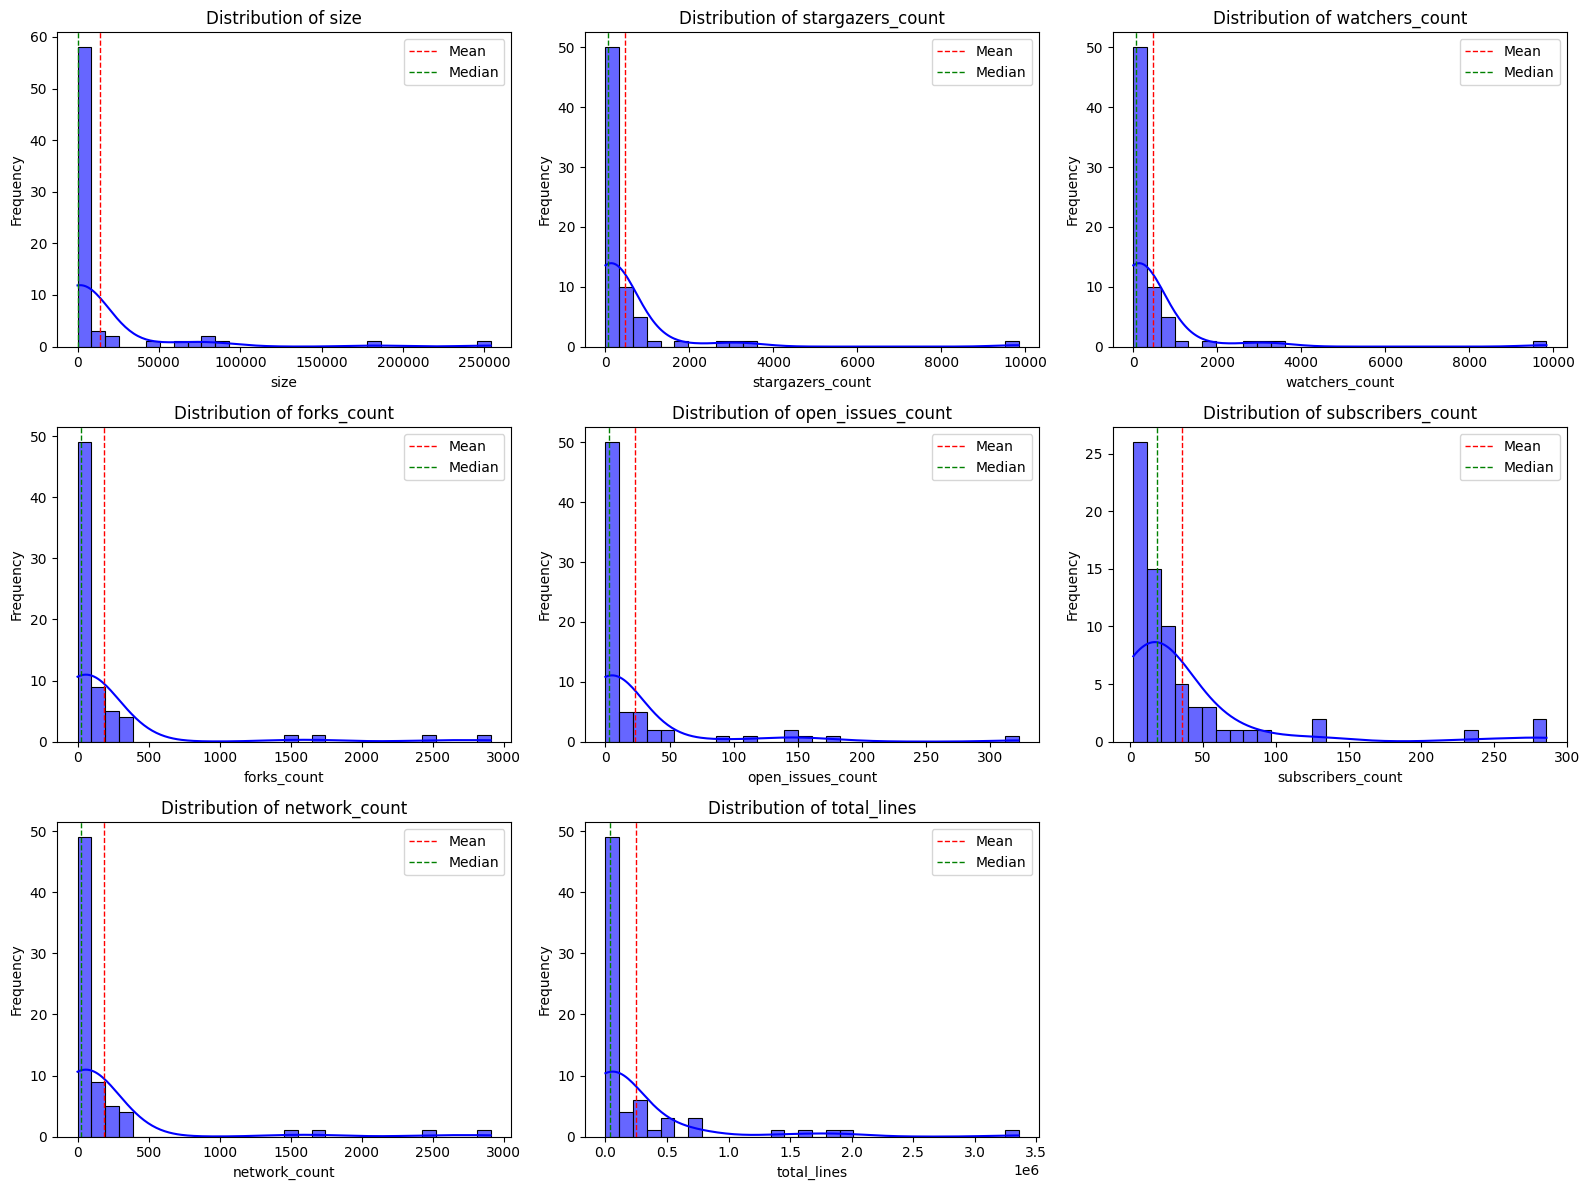

In [366]:
plot_metrics_distribution()

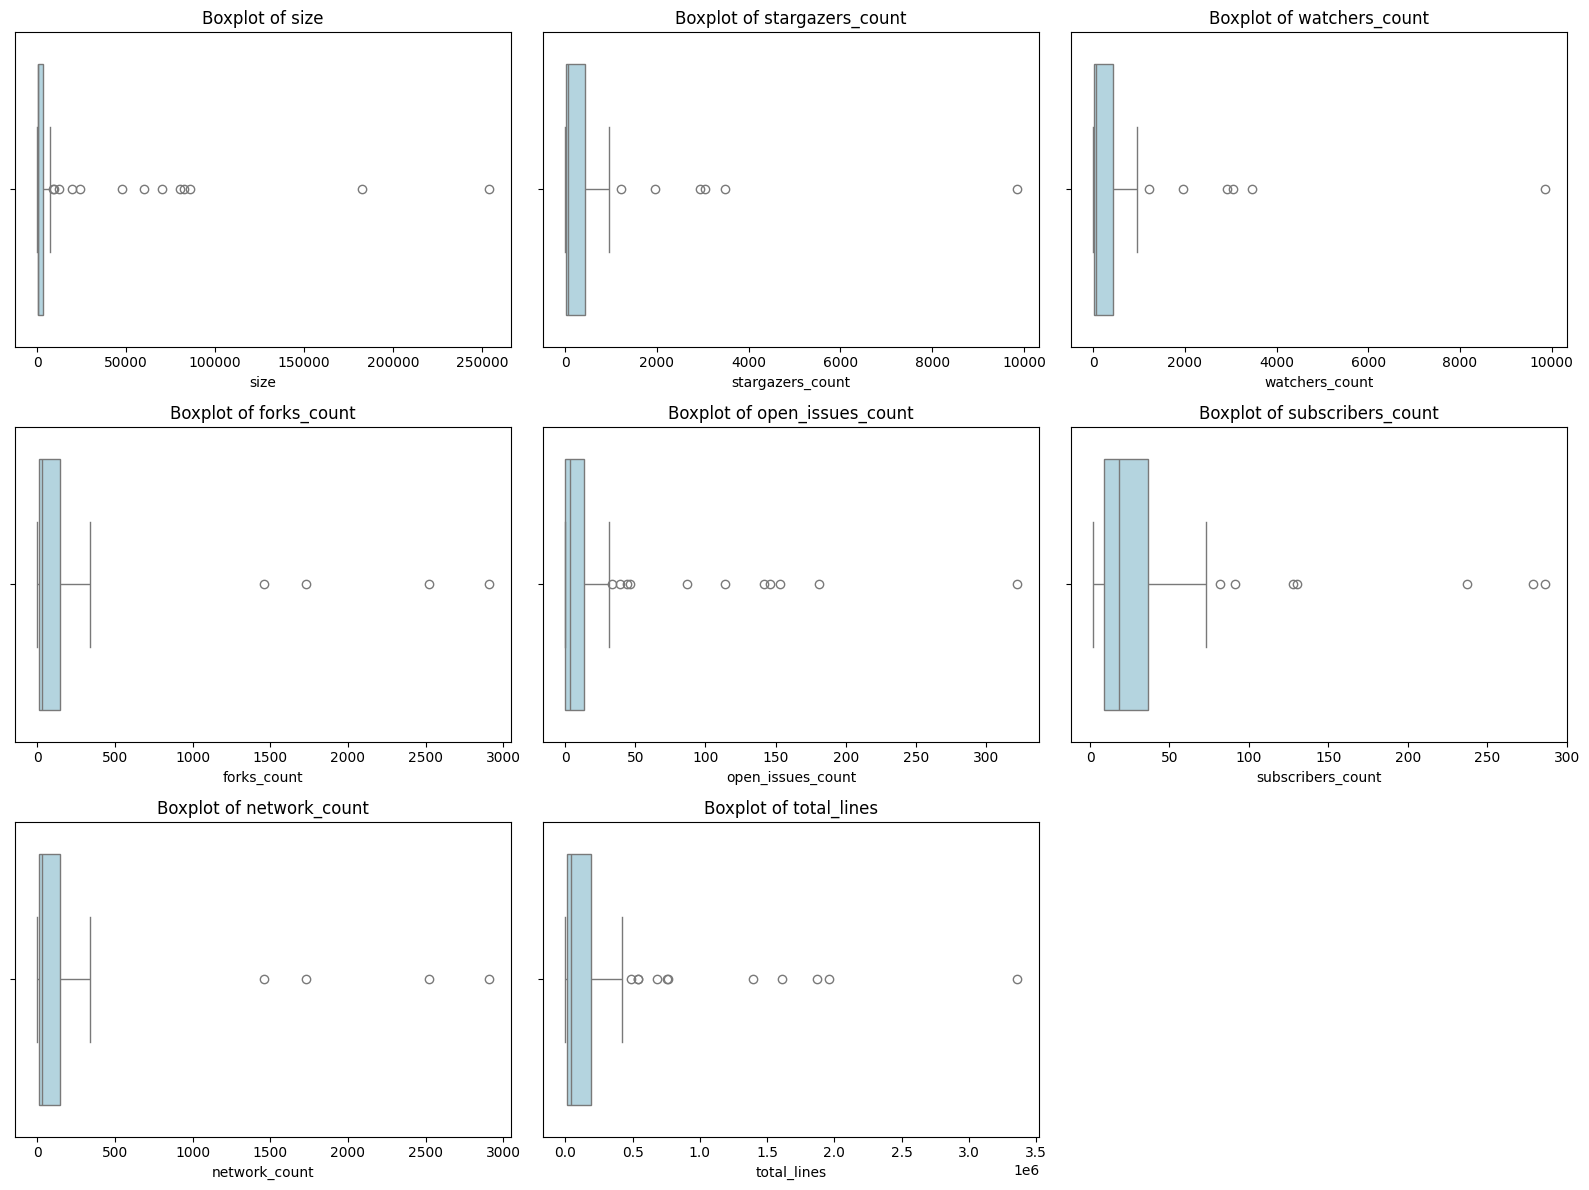

In [367]:
plot_boxplot_metrics()

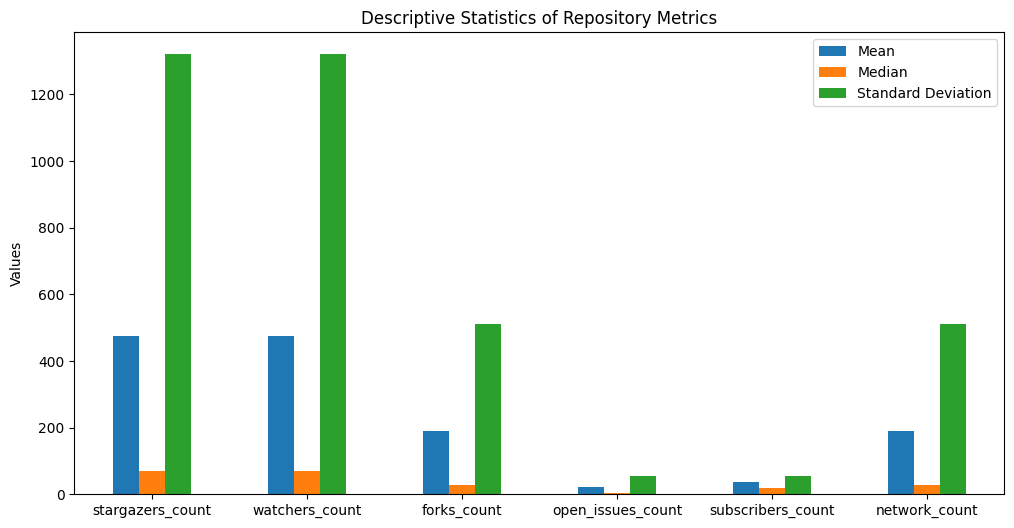

In [368]:
plot_metrics_statistics()